## Things Left:
* Data Splitting into train, val, test - **Done**
* Update Datasets for torch dataloader - **Done**
* Update Models - **Done**
* Training loop Update
    * loss function
    * regularization of intermediate layer in word predict sub network
    * do context updates consecutively or seperate
* Attention Network Weights
    * For each token in our dataset
        * aggregate the attention weight
    * Rank each token
    * Check the change in Rank when compairing single task vs multitask
* Compare the use of loss weights
* Compare the use of context word from headline vs body of the news article

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [256]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from Scripts.utils.bert_utils import load_tokenizer
import  gc
import time
import pickle
import dill
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch
from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen
from tqdm import tqdm
import h5py
import random

In [96]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True

In [5]:
top_10_sim_cps = load_pickle("current_pickle_obs/top10cp.pickle")
doc_2_cluster_map = load_pickle("current_pickle_obs/doc_2_cluster_map.pickle")
rel_df = load_pickle("current_pickle_obs/rel_df_with_wp.pickle")

In [6]:
top_10_sim_cps

[(58, 59),
 (123, 59),
 (66, 8),
 (47, 49),
 (58, 66),
 (349, 63),
 (81, 349),
 (306, 281),
 (23, 156),
 (66, 59),
 (123, 58),
 (49, 306),
 (58, 8),
 (23, 306),
 (173, 314),
 (126, 301),
 (220, 98),
 (123, 66),
 (81, 63),
 (23, 49)]

In [7]:
rel_df["doc_indices"] = rel_df.index

In [8]:
rel_df.head(1)

,title,text,source_partisan_score,binary_ps,processed_text,all_text,Num_Tokens,processed_title,Num_Tokens_HL,context_pos_words,context_neg_words,context_pos_words_body,context_neg_words_body,doc_indices
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,293,top general warns that divisiveness leads to d...,14,"[general, warns, pentagon]","[entry, stephen, standards]","[pol, median, counsel]","[contradiction, spear, rang]",0


## Data Splitting

In [9]:
def balance_classes(df):
    """
    """
    min_partisan = df.binary_ps.value_counts().min()
    
    df_0 = df[df.binary_ps == 0].sample(min_partisan,random_state=42)
    df_1 = df[df.binary_ps == 1].sample(min_partisan,random_state=42)
    
    df = pd.concat((df_0,df_1)).sample(frac=1,random_state=42)
    
    return df

def get_label_dist(labels):
    """
    """
    print("1 : %s" %str(sum(labels)))
    print("0 : %s" %str(len(labels) - sum(labels)))


def split_data(cluster_pair,cluster_2_doc_map,df):
    """
    """
    c1_df = df.iloc[cluster_2_doc_map[cluster_pair[0]]]
    c2_df = df.iloc[cluster_2_doc_map[cluster_pair[1]]]
    
    print("C1 Shape : %s" %str(c1_df.shape))
    print("C2 Shape : %s" %str(c2_df.shape))
    
    c1_df["which_cluster"] = [1]*c1_df.shape[0]
    c2_df["which_cluster"] = [2]*c2_df.shape[0]
    
    # drop rows where context words are absent
    c1_df["context_pos_words_size"] = c1_df["context_pos_words"].apply(lambda x: len(x))
    c1_df = c1_df[c1_df["context_pos_words_size"] > 0]
    
    c2_df["context_pos_words_size"] = c2_df["context_pos_words"].apply(lambda x: len(x))
    c2_df = c2_df[c2_df["context_pos_words_size"] > 0]
    
    c1_df = balance_classes(c1_df)
    c2_df = balance_classes(c2_df)
    
    # Flip c2 labels
    c2_df["binary_ps"] = c2_df["binary_ps"].apply(lambda x: np.abs(x+(-1)))
    
    print("Data Shape after balancing :")
    print("C1 Shape : %s" %str(c1_df.shape))
    print("C2 Shape : %s" %str(c2_df.shape))
    
    strata_columns = "binary_ps"
    
    # Train - 90% c1, 10% c2
    c1_train, c1_test = train_test_split(c1_df,test_size=0.20, stratify=c1_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c1_train, c1_val = train_test_split(c1_train,test_size=0.10,stratify=c1_train[strata_columns], random_state=CONFIG.RANDOM_SEED)
    c2_df_train,c2_df_test = train_test_split(c2_df,train_size=int(0.1*c1_train.shape[0]),stratify=c2_df[strata_columns], random_state=CONFIG.RANDOM_SEED)
    train = pd.concat([c1_train,c2_df_train],axis=0).sample(frac=1,random_state=42)
    
    # Test - 50% c1 , 50% c2
    c2_test_,c2_val_temp = train_test_split(c2_df_test,train_size=c1_test.shape[0],stratify=c2_df_test[strata_columns], random_state=CONFIG.RANDOM_SEED)
    test = pd.concat([c1_test,c2_test_],axis=0).sample(frac=1,random_state=42)
    
    # Val - 90% c1, 10% c2
    c2_val , _ = train_test_split(c2_val_temp,train_size=int(c1_val.shape[0]*0.10),stratify=c2_val_temp[strata_columns], random_state=CONFIG.RANDOM_SEED)
    val = pd.concat([c1_val,c2_val],axis=0).sample(frac=1,random_state=42)
    
    print("Data Sizes :")
    print("Train : %s" %str(train.shape))
    print("Val : %s" %str(val.shape))
    print("Test : %s" %str(test.shape))
    
    print("Label Distributions :")
    print("Train :")
    get_label_dist(train["binary_ps"])
    print("Val : ")
    get_label_dist(val["binary_ps"])
    print("Test : ")
    get_label_dist(test["binary_ps"])
    
    return train, test, val
    

# 173 - Immigration/ border wall
# 220 - Gun Control

In [10]:
train,test,val = split_data(cluster_pair=(220,173),cluster_2_doc_map=doc_2_cluster_map,df=rel_df)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


In [11]:
train = train[train.doc_indices <= 99402 ]
test = test[test.doc_indices <= 99402 ]
val = val[val.doc_indices <= 99402 ]

In [12]:
print(train.shape)
print(test.shape)
print(val.shape)

(779, 16)
(397, 16)
(88, 16)


In [10]:
train = train[train.doc_indices <= 99402 ]

In [11]:
train.shape

(779, 16)

In [12]:
val.head(1)

,title,text,source_partisan_score,binary_ps,processed_text,all_text,Num_Tokens,processed_title,Num_Tokens_HL,context_pos_words,context_neg_words,context_pos_words_body,context_neg_words_body,doc_indices,which_cluster,context_pos_words_size
88595,Where Kamala Harris stands on the biggest 2020...,Sen . Michael Bennet told CBS News the Senate ...,-1.0,0,sen michael bennet told cbs news the senate sh...,where kamala harris stands on the biggest 2020...,168,where kamala harris stands on the biggest 2020...,9,"[2020, harris, biggest]","[threaten, keeping, fate]","[pol, loop, julian]","[emmy, barr, shout]",88595,1,3


## Torch Datasets for Dataloaders

In [211]:
class CPDatasetST(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5"):
        self.df = df
        self.hdf_path = hdf_file_path
        self.h5file = h5py.File(self.hdf_path, "r")
        self.d_set = self.h5file.get("bert_embeds")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        x1 = self.d_set[self.df["doc_indices"].iloc[index],:,:]
        
        x1 = torch.Tensor(x1)
        

        return x1, y1, t1, wc

# For the multitask, each _getitem_ will not return a single item for context words but the list of words, where multiple updates for each sample should occur in train

def get_bert_embeddings(df,model,tokenizer):
    """
    should return a list of dictionaries where dictionary has context word embedding and label
    """
    
    texts_pos = df["context_pos_words"].tolist()
    texts_neg = df["context_neg_words"].tolist()
    single_pos = [pos[0] for pos in texts_pos]
    single_neg = [neg[0] for neg in texts_neg]
    
    embeds_list = []
    
    with torch.no_grad():
        for i in tqdm(range(len(texts_pos)),total=len(texts_pos)):
            
            embed_dict = {}

            encoded_pos = tokenizer.encode_plus(texts_pos[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            encoded_neg = tokenizer.encode_plus(texts_neg[i], add_special_tokens=False, max_length = 1, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')

            token_pos = encoded_pos["input_ids"]
            token_neg = encoded_neg["input_ids"]

            token_tensors = torch.cat([token_pos,token_neg],dim=0)
            token_tensors = token_tensors.to(torch.device('cuda:1'))
            batch_out = model(token_tensors)
            batch_hidden_states = batch_out[2]
            batch_12_layer_tensor = batch_hidden_states[-1]

            pos_embed = batch_12_layer_tensor[0,:,:].cpu()
            neg_embed = batch_12_layer_tensor[1,:,:].cpu()
            
            embed_dict["pos"] = pos_embed
            embed_dict["neg"] = neg_embed
            
            embeds_list.append(embed_dict)
    
    return embeds_list
        

class CPDatasetMT(torch.utils.data.Dataset):
    """
    Should return bert embedding, label, which cluster, actual text
    Simple case no context word
    """
    def __init__(self, df,embeds_list,hdf_file_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",context_word_sample_size=2):
        self.df = df
        self.hdf_path = hdf_file_path
        self.h5file = h5py.File(self.hdf_path, "r")
        self.d_setx1 = self.h5file.get("bert_embeds")
        self.embeds_list = embeds_list

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        t1 = self.df["all_text"].iloc[index]
        y1 = self.df["binary_ps"].iloc[index]
        wc = self.df["which_cluster"].iloc[index]
        
        
        y1 = torch.Tensor([y1])
        wc = torch.Tensor([wc])
        x1 = self.d_setx1[self.df["doc_indices"].iloc[index],:,:]
        
        # create a dictionary of tensors here, with labels
        #{pos_embeds, pos_labels, neg_embeds, neg_labels}
        x2 = torch.cat([self.embeds_list[index]["pos"],self.embeds_list[index]["neg"]],dim=0)
        x1 = torch.Tensor(x1)
        return x1, x2, y1, t1, wc

In [14]:
train_dataset = CPDatasetST(train)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(y1.shape)
    print(wc.shape)

0
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
1
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
2
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
3
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
4
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
5
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
6
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
7
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
8
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
9
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
10
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
11
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
12
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
13
torch.Size([32, 350, 768])
torch.Size([32, 1])
torch.Size([32, 1])
14
torch.Size([32, 350, 768])


In [20]:
model = load_model()
model.to(torch.device('cuda:1'))
model.eval()
tokenizer = load_tokenizer()

embeds_list_hl_context_words = get_bert_embeddings(train,model,tokenizer)

100%|██████████| 779/779 [00:05<00:00, 143.03it/s]


In [21]:
len(embeds_list_hl_context_words)

779

In [22]:
embeds_list_hl_context_words[0]['pos'].size()

torch.Size([1, 768])

In [34]:
train_mt = CPDatasetMT(train,embeds_list_hl_context_words)
train_dataloader = DataLoader(train_mt,batch_size=32,num_workers=1,shuffle=True)

for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
    print(batch_num)
    print(x1.shape)
    print(x2.shape)
    print(y1.shape)
    print(wc.shape)
    
#     print(x2)
    break

0
torch.Size([32, 350, 768])
torch.Size([32, 2, 768])
torch.Size([32, 1])
torch.Size([32, 1])


## Models

In [21]:
class AttentionST(nn.Module):
    
    def __init__(self,embedding_size=768,verbose=True,which_forward=2,with_attention=True,dropout=0.3):
        super(AttentionST,self).__init__()
        
        self.with_attention = with_attention
        
        self.attention = nn.Linear(in_features=embedding_size,
                                       out_features=1,
                                       bias=False)
        
        
        self.dropout = nn.Dropout(dropout)
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)

        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self,embeddings):
        """
        """
        
        
        if self.with_attention:
        # iterate over articles in a given batch
            attention_vector_batch = []

            for sent in range(embeddings.size(0)):

                sent_embed_matrix = embeddings[sent,:,:] # 500 x 768

                word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

                self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

                attention_vector = sent_embed_matrix.T .mul(self.normalized_word_weights).sum(dim=1)

                attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                

            attention_vector_batch = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)
            
            y_preds = self.sigmoid(self.recom_pred(attention_vector_batch)).squeeze()
        
            return y_preds
        
        else:
            
            y_pred = self.sigmoid(self.recom_pred(embeddings[:,0,:])).squeeze()
            
            return y_pred


        

class AttentionMT(nn.Module):
    
    def __init__(self,embedding_size=768,dropout=0.1):
        super(AttentionMT,self).__init__()
        
        self.attention = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=False)
        
        self.interm_word = nn.Linear(in_features=embedding_size,
                                    out_features=embedding_size,
                                    bias=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.word_weights = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=True)
        
        # Recommendation Network
        # ------------------------
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)
        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,text_embeds,context_embed):
        """
        """
        attention_vector_batch = []
        
        for sent in range(text_embeds.size(0)):

            sent_embed_matrix = text_embeds[sent,:,:] # 500 x 768

            word_weights = self.dropout(self.attention(sent_embed_matrix)).squeeze()

            self.normalized_word_weights = self.softmax(word_weights) # input is 500 x 1, output is 500 x 1

            attention_vector = sent_embed_matrix.T.mul(self.normalized_word_weights).sum(dim=1)

            attention_vector_batch.append(attention_vector.unsqueeze(-1).T) 
                
                
        attention_vector_batch = torch.cat(attention_vector_batch,dim=0) # we get (batch_size,768)

        y_preds = self.sigmoid(self.recom_pred(attention_vector_batch))
        
        
        word_preds = None
        
        if context_embed is not None:
        # Word Prediction Part
        
            # convert 3d to 2d matrix
            original_size = context_embed.size()
            context_embed = context_embed.view(original_size[0],original_size[-1])
#             context_embed = self.sigmoid(self.dropout(self.interm_word(context_embed)))

            dot_prod_sim = torch.mul(attention_vector_batch, context_embed) # dot product between (N,768) and (N,768)

            word_preds = self.sigmoid(self.word_weights(dot_prod_sim))

            word_preds = word_preds.view(word_preds.size()[0],1)
        
        return y_preds,word_preds

## Train Code

In [50]:
@timer
def run_ssda_ST(train,test,val,lr,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True,cp=None):
    """
    """
    model = AttentionST(embedding_size=768,with_attention=with_attention,dropout = dropout)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    total_losses_val = []
    word_losses = []
    rs_losses = []
    
    
    train_dataset = CPDatasetST(train)
    test_dataset = CPDatasetST(test)
    val_dataset = CPDatasetST(val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=100,num_workers=num_workers,shuffle=True)
    val_dataloader = DataLoader(val_dataset,batch_size=100,num_workers=num_workers,shuffle=True)
    
    for epoch in tqdm(range(epochs),total=epochs):
        batch_losses =  []
        # Training
        for batch_num, (x1,y1,t1,wc) in enumerate(train_dataloader):
            
            model.train()

            x1,y1 = x1.to(cuda_device),y1.to(cuda_device)
            
            opt.zero_grad() # reset all the gradient information
    
            y_pred = model(x1)
            
            if batch_size == 1:
                y1 = y1.view(1)
            
            if batch_size > 1:
                y1 = y1.squeeze()
            
            total_loss = loss_func(y_pred,y1.squeeze()) 
            
            total_loss.backward()
            
            opt.step()
            
            batch_losses.append(total_loss.item())
        
        # Validation
        batch_losses_val =  []
        for bn_v, (xv1,yv1,tv1,wcv) in enumerate(val_dataloader):
            
            model.eval()
            with torch.no_grad():
                xv1,yv1 = xv1.to(cuda_device),yv1.to(cuda_device)

                y_pred = model(xv1)
                
                if batch_size == 1:
                    yv1 = yv1.view(1)
            
                if batch_size > 1:
                    yv1 = yv1.squeeze()

                total_loss_val = loss_func(y_pred,yv1) 
                batch_losses_val.append(total_loss_val.item())
        
        avg_batch_loss = np.mean(batch_losses)
        avg_batch_loss_val = np.mean(batch_losses_val)
        total_losses.append(avg_batch_loss)
        total_losses_val.append(avg_batch_loss_val)

        
    epoch_losses["total_loss"] = total_losses
    epoch_losses["total_loss_val"] = total_losses_val
        
    scores_train = evaluate_st(model,train_dataloader,device=cuda_device)
    scores_test = evaluate_st(model,test_dataloader,device=cuda_device)
    
    x1 = None
    y1 = None
    total_loss = None
    opt = None
    

    del x1
    del y1

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test


@timer
def run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,lr,word_loss_w,epochs=2,batch_size=8,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,l2=0.05):
    """
    """
    model = AttentionMT(embedding_size=768,dropout=dropout)
    model.to(cuda_device)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    epoch_losses = {}
    total_losses = []
    word_losses = []
    rs_losses = []
    total_losses_val = []
    word_losses_val = []
    rs_losses_val = []
    
    train_dataset = CPDatasetMT(train,cw_embed_train)
    test_dataset = CPDatasetMT(test,cw_embed_test)
    val_dataset = CPDatasetMT(val,cw_embed_val)
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers, shuffle=True)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
    val_dataloader = DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
        
    for epoch in tqdm(range(epochs),total=epochs):
        
        batch_losses_total = []
        batch_losses_rec = []
        batch_losses_word = []
        
        for batch_num, (x1, x2, y1, t1, wc) in enumerate(train_dataloader):
            
            # doing single updates
            for label_cw in range(2):
                
                # expand the context words 
                
                context_word_embed = x2[:,label_cw,:]
                if label_cw == 0:
                    word_labels = torch.Tensor([1]*x2.size()[0])
                
                if label_cw == 1:
                    word_labels = torch.Tensor([0]*x2.size()[0])
                
#                 context_word_embeds = torch.cat(context_word_embed,dim=0)
            
                model.train()

                x1,context_word_embed,y1,word_labels = x1.to(cuda_device),context_word_embed.to(cuda_device),y1.to(cuda_device),word_labels.to(cuda_device)

                opt.zero_grad() # reset all the gradient information

                y_pred, context_pred = model(x1, context_word_embed)

                rec_loss = loss_func(y_pred,y1)
                word_loss = loss_func(context_pred.squeeze(),word_labels)

                total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss) + model.word_weights.weight.norm(p=2) * l2

                total_loss.backward()

                opt.step()

                batch_losses_rec.append(rec_loss.item())
                batch_losses_word.append(word_loss.item())
                batch_losses_total.append(total_loss.item())
            
        avg_batch_losses_total = np.mean(batch_losses_total)
        avg_batch_losses_rec = np.mean(batch_losses_rec)
        avg_batch_losses_word = np.mean(batch_losses_word)
#         print("Avg Batch Total Loss Train : %s" %str(avg_batch_losses_total))
        
        
        batch_losses_total_val = []
        batch_losses_rec_val = []
        batch_losses_word_val = []

        for bn_v, (x1v, x2v, y1v, t1v, wcv) in enumerate(val_dataloader):

            model.eval()
            with torch.no_grad():
                
                for label_cw in range(2):
                    
                    context_word_embed = x2v[:,label_cw,:]
                    if label_cw == 0:
                        word_labels = torch.Tensor([1]*x1v.size()[0])

                    if label_cw == 1:
                        word_labels = torch.Tensor([0]*x1v.size()[0])

#                     context_word_embeds = torch.cat(context_word_embed,dim=0)
            
                    x1v,context_word_embed,y1v,word_labels = x1v.to(cuda_device),context_word_embed.to(cuda_device),y1v.to(cuda_device),word_labels.to(cuda_device)

                    y_pred, context_pred = model(x1v, context_word_embed)

                    if batch_size == 1:
                        y_pred = y_pred.view(1,1)
                        context_pred = context_pred.view(1,1)

                    rec_loss = loss_func(y_pred,y1v)
                    word_loss = loss_func(context_pred.squeeze(),word_labels)

                    total_loss = (1 - word_loss_w)*rec_loss + (word_loss_w * word_loss)

                    batch_losses_total_val.append(rec_loss.item())
                    batch_losses_word_val.append(word_loss.item())
                    batch_losses_rec_val.append(total_loss.item())
        

        avg_batch_losses_total_val =np.mean(batch_losses_total_val)
        avg_batch_losses_rec_val = np.mean(batch_losses_rec_val)
        avg_batch_losses_word_val =np.mean(batch_losses_word_val)
#         print("Avg Batch Toal Loss Val : %s" %str(avg_batch_losses_total_val))

        total_losses.append(avg_batch_losses_total)
        word_losses.append(avg_batch_losses_word)
        rs_losses.append(avg_batch_losses_rec)
        total_losses_val.append(avg_batch_losses_total_val)
        word_losses_val.append(avg_batch_losses_word_val)
        rs_losses_val.append(avg_batch_losses_rec_val)
            
    epoch_losses["rs_loss"] = rs_losses
    epoch_losses["word_loss"] = word_losses
    epoch_losses["total_loss"] = total_losses
    epoch_losses["rs_loss_val"] = rs_losses_val
    epoch_losses["word_loss_val"] = word_losses_val
    epoch_losses["total_loss_val"] = total_losses_val

    scores_train = evaluate_mt(model,train_dataloader,device=cuda_device)
    scores_test = evaluate_mt(model,test_dataloader,device=cuda_device)
    
    x1 = None
    x2 = None
    y1 = None
    y2 = None
    rec_loss = None
    total_loss = None
    word_loss = None
    opt = None
    

    del x1
    del x2
    del y1
    del y2

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train, scores_test

In [13]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

In [88]:
model, epoch_losses, scores_train, scores_test = run_ssda_ST(train,test,val,lr=0.0001,epochs=5,batch_size=16,dropout=0.1,cuda_device=torch.device('cuda:1'),num_workers=1,with_attention=True)

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Y1 Pred Dist : 
1 : 242
0 : 408
Predicted Label Shape : (650,)
True Label Shape : (650,)
Predicted Label Shape : (591,)
True Label Shape : (591,)
Predicted Label Shape : (59,)
True Label Shape : (59,)

Finished running 'evaluate_st' in 0.0092 mins

Y1 Pred Dist : 
1 : 130
0 : 200
Predicted Label Shape : (330,)
True Label Shape : (330,)
Predicted Label Shape : (165,)
True Label Shape : (165,)
Predicted Label Shape : (165,)
True Label Shape : (165,)

Finished running 'evaluate_st' in 0.0063 mins


Finished running 'run_ssda_ST' in 0.0765 mins



In [89]:
scores_test

defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.4421768707482993,
                                       'precision': 0.5,
                                       'recall': 0.39634146341463417,
                                       'accuracy': 0.5023875991771967,
                                       'roc_auc': 0.503030303030303})}),
             'cluster1': defaultdict(<function attm_metrics.calculate_scores_single.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.4358974358974359,
                                       'precision': 0.4594594594594595,
                                       'recall': 0.4146341463414634,
        

In [17]:
bmodel = load_model()
bmodel.to(torch.device('cuda:1'))
bmodel.eval()
tokenizer = load_tokenizer()

cw_embed_train = get_bert_embeddings(train,bmodel,tokenizer)
cw_embed_test = get_bert_embeddings(test,bmodel,tokenizer)
cw_embed_val = get_bert_embeddings(val,bmodel,tokenizer)

100%|██████████| 88/88 [00:00<00:00, 143.02it/s]


In [26]:
model, epoch_losses, scores_train, scores_test = run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,
                                                             lr=0.001,
                                                             word_loss_w=0.4,
                                                             epochs=10,
                                                             batch_size=16,
                                                             dropout=0.3,
                                                             cuda_device=torch.device('cuda:1'),num_workers=1)

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 437
0 : 342
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0071 mins


Finished running 'run_ssda_MT' in 0.2051 mins



In [27]:
scores_test

defaultdict(<function attm_metrics.calculate_scores.<locals>.<lambda>()>,
            {'overall': defaultdict(<function attm_metrics.calculate_scores.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'class_scores': defaultdict(float,
                                      {'f1': 0.5384615384615384,
                                       'precision': 0.5137614678899083,
                                       'recall': 0.5656565656565656,
                                       'accuracy': 0.5164966245368257,
                                       'roc_auc': 0.5163727959697733}),
                          'word_scores': defaultdict(float,
                                      {'f1': 0.0,
                                       'precision': 0.0,
                                       'recall': 0.0,
                                       'accuracy': 0.0,
                                       'roc_auc': 1.0})}),
             'cluster1': defaultdict(<function attm_metrics.calc

## Main Runner

In [32]:
def run_ssda_cp_st(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   batch_sizes=[8],
                   dropouts=[0.0,0.1,0.3,0.5],
                   with_attention=True,
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
    train = train[train.doc_indices <= 99402 ]
    test = test[test.doc_indices <= 99402 ]
    val = val[val.doc_indices <= 99402 ]
    
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    model_dict = {}
    # train ssda func
    params = [learning_rates,epochs,batch_sizes,dropouts]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        
        model, epoch_losses, scores_train, scores_test  = run_ssda_ST(train,
                                                                     test,
                                                                     val,
                                                                     lr,
                                                                     epochs=epoch,
                                                                     batch_size=batch_size,
                                                                     dropout = dropout,
                                                                     cuda_device=cuda_device,
                                                                     num_workers=1,
                                                                     with_attention=with_attention)

        metrics_train[(lr,epoch,batch_size,dropout)] = scores_train
        metrics_test[(lr,epoch,batch_size,dropout)] = scores_test
        losses_train[(lr,epoch,batch_size,dropout)] = epoch_losses
        
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout)] = model
            
    return metrics_train,metrics_test, losses_train,model_dict



def run_ssda_cp_mt(df,cp,doc_2_cluster_map,
                   learning_rates=[0.0001,0.001,0.01,0.1],
                   epochs=[3],
                   word_pred_loss_weights=[0.3,0.8],
                   batch_sizes=[8],
                   dropouts=[0.1],
                   cuda_device=torch.device('cuda:1'), 
                   return_model=False):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test, val = split_data(cluster_pair=cp,cluster_2_doc_map=doc_2_cluster_map,df=df)
    
    train = train[train.doc_indices <= 99402 ]
    test = test[test.doc_indices <= 99402 ]
    val = val[val.doc_indices <= 99402 ]
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    tokenizer = load_tokenizer()

    cw_embed_train = get_bert_embeddings(train,bmodel,tokenizer)
    cw_embed_test = get_bert_embeddings(test,bmodel,tokenizer)
    cw_embed_val = get_bert_embeddings(val,bmodel,tokenizer)
    
    
    metrics_train = {}
    metrics_test = {}
    losses_train = {}
    model_dict = {}
    params = [learning_rates,epochs,batch_sizes,dropouts,word_pred_loss_weights]
    
    params_all_combo = list(itertools.product(*params))
    
    print("Number of param combinations : %s" %str(len(params_all_combo)))
    
    for p_id,param_list in enumerate(params_all_combo):
        
        print("Param_setting : %s" %str(p_id))
        
        lr = param_list[0]
        epoch = param_list[1]
        batch_size = param_list[2]
        dropout=param_list[3]
        wlw = param_list[4]
        
        print("Running model for ----\n lr : %s\n epoch : %s\n batch_size : %s\n dropout : %s\n"%(str(lr),str(epoch),str(batch_size),str(dropout)))
        
        model = None
        gc.collect()
        torch.cuda.empty_cache()
        

        model, epoch_losses, scores_train, scores_test = run_ssda_MT(train,test,val,cw_embed_train,cw_embed_test,cw_embed_val,
                                                                     lr,wlw,epochs=epoch,batch_size=batch_size,dropout=dropout,cuda_device=cuda_device,num_workers=1)
        metrics_train[(lr,epoch,batch_size,dropout,wlw)] = scores_train
        metrics_test[(lr,epoch,batch_size,dropout,wlw)] = scores_test
        losses_train[(lr,epoch,batch_size,dropout,wlw)] = epoch_losses
        if return_model:
            model_dict[(lr,epoch,batch_size,dropout)] = model
            
    return metrics_train,metrics_test, losses_train,model_dict

In [24]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001,0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       batch_sizes=[8,16,32,64],
                                                                       with_attention=False,
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

  0%|          | 0/4 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 461
0 : 318
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 248
0 : 149
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0863 mins

Param_setting : 1
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 498
0 : 281
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0861 mins

Param_setting : 2
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 116
0 : 663
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0136 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 48
0 : 349
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0888 mins

Param_setting : 3
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 426
0 : 353
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 196
0 : 201
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 4
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 455
0 : 324
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 213
0 : 184
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.0886 mins

Param_setting : 5
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Y1 Pred Dist : 
1 : 501
0 : 278
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 250
0 : 147
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0891 mins

Param_setting : 6
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 412
0 : 367
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 207
0 : 190
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0836 mins

Param_setting : 7
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 430
0 : 349
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 206
0 : 191
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 424
0 : 355
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 200
0 : 197
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0863 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 336
0 : 443
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 160
0 : 237
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0830 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 316
0 : 463
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 175
0 : 222
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 354
0 : 425
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 336
0 : 443
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 174
0 : 223
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1490 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 612
0 : 167
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 301
0 : 96
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1509 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 466
0 : 313
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1510 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 359
0 : 420
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1463 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 360
0 : 419
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 187
0 : 210
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1454 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 369
0 : 410
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1462 mins

Param_setting : 18
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 345
0 : 434
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 196
0 : 201
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1442 mins

Param_setting : 19
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 381
0 : 398
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1445 mins

Param_setting : 20
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 171
0 : 226
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 21
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 291
0 : 488
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 140
0 : 257
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1460 mins

Param_setting : 22
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 329
0 : 450
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 167
0 : 230
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1450 mins

Param_setting : 23
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 308
0 : 471
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 145
0 : 252
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1448 mins

Param_setting : 24
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 234
0 : 545
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 126
0 : 271
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2122 mins

Param_setting : 25
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 285
0 : 494
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 145
0 : 252
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.2142 mins

Param_setting : 26
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 462
0 : 317
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 237
0 : 160
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2102 mins

Param_setting : 27
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 352
0 : 427
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 172
0 : 225
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2063 mins

Param_setting : 28
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 425
0 : 354
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 221
0 : 176
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2073 mins

Param_setting : 29
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 376
0 : 403
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 184
0 : 213
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2101 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 487
0 : 292
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 258
0 : 139
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2032 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 442
0 : 337
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 219
0 : 178
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2036 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 338
0 : 441
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 177
0 : 220
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2046 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 455
0 : 324
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2069 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 359
0 : 420
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2071 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 404
0 : 375
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.2099 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 778
0 : 1
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 397
0 : 0
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predicitions for class labels
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0858 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 92
0 : 687
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 43
0 : 354
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0084 mins


Finished running 'run_ssda_ST' in 0.0869 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 690
0 : 89
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 346
0 : 51
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0866 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 564
0 : 215
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 290
0 : 107
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0848 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 589
0 : 190
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins

Y1 Pred Dist : 
1 : 289
0 : 108
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0853 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 97
0 : 682
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 45
0 : 352
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0843 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 388
0 : 391
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0839 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 7
0 : 772
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 395
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0843 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 763
0 : 16
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 383
0 : 14
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.0846 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 660
0 : 119
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 327
0 : 70
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 549
0 : 230
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 275
0 : 122
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 759
0 : 20
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 386
0 : 11
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0831 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 714
0 : 65
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 366
0 : 31
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1478 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 534
0 : 245
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 283
0 : 114
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1481 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 342
0 : 437
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1458 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 682
0 : 97
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 344
0 : 53
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1440 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 144
0 : 635
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 71
0 : 326
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 114
0 : 665
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 44
0 : 353
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.1455 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 280
0 : 499
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 138
0 : 259
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1426 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 613
0 : 166
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 308
0 : 89
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1418 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 226
0 : 553
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 111
0 : 286
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1422 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 398
0 : 381
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1436 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 357
0 : 422
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 186
0 : 211
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.1444 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 645
0 : 134
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 322
0 : 75
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1453 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 386
0 : 393
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 199
0 : 198
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2146 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 742
0 : 37
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 381
0 : 16
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2115 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 124
0 : 655
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 45
0 : 352
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2087 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 386
0 : 393
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 205
0 : 192
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2076 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 71
0 : 708
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.2091 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 562
0 : 217
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 279
0 : 118
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2087 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 738
0 : 41
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 374
0 : 23
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2052 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 453
0 : 326
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2038 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 337
0 : 442
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 183
0 : 214
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2051 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 629
0 : 150
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 322
0 : 75
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2035 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 454
0 : 325
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2022 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 144
0 : 635
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 70
0 : 327
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2040 mins

Param_setting : 72
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 146
0 : 633
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 70
0 : 327
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0079 mins


Finished running 'run_ssda_ST' in 0.0861 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 11
0 : 768
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0127 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 2
0 : 395
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0857 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 483
0 : 296
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0876 mins

Param_setting : 75
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 6
0 : 773
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 1
0 : 396
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0856 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 100
0 : 679
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0126 mins

Y1 Pred Dist : 
1 : 44
0 : 353
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0859 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 353
0 : 426
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 176
0 : 221
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0849 mins

Param_setting : 78
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 214
0 : 565
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 117
0 : 280
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.0834 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 126
0 : 653
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 61
0 : 336
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0835 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 450
0 : 329
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0825 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 156
0 : 623
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 69
0 : 328
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.0819 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 748
0 : 31
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 379
0 : 18
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0825 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 101
0 : 678
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 41
0 : 356
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.0832 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 181
0 : 598
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 92
0 : 305
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1476 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 424
0 : 355
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 223
0 : 174
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1503 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 71
0 : 708
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 29
0 : 368
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1481 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 377
0 : 402
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 212
0 : 185
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1426 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1437 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 445
0 : 334
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 232
0 : 165
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1484 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 195
0 : 584
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins

Y1 Pred Dist : 
1 : 93
0 : 304
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1460 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 227
0 : 552
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0116 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 114
0 : 283
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1434 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 537
0 : 242
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 277
0 : 120
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1419 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 662
0 : 117
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 326
0 : 71
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.1422 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 715
0 : 64
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 359
0 : 38
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.1439 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 735
0 : 44
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 376
0 : 21
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.1436 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Y1 Pred Dist : 
1 : 703
0 : 76
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 359
0 : 38
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2112 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 187
0 : 592
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0125 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 89
0 : 308
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2134 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 57
0 : 722
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2135 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 185
0 : 594
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0119 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 88
0 : 309
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0077 mins


Finished running 'run_ssda_ST' in 0.2070 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 123
0 : 656
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 49
0 : 348
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2069 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2119 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 62
0 : 717
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 25
0 : 372
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2049 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 295
0 : 484
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 155
0 : 242
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2016 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 618
0 : 161
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0118 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 323
0 : 74
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2013 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 763
0 : 16
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 389
0 : 8
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0074 mins


Finished running 'run_ssda_ST' in 0.2032 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 547
0 : 232
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 286
0 : 111
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0076 mins


Finished running 'run_ssda_ST' in 0.2036 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 438
0 : 341
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0117 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0075 mins


Finished running 'run_ssda_ST' in 0.2019 mins



In [25]:
print_res(metrics_test).to_csv("(220,173)_single_test_scores.csv",index=False)

In [15]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001,0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       batch_sizes=[8,16,32,64],
                                                                       with_attention=True,
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 626
0 : 153
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins



  0%|          | 0/4 [00:00<?, ?it/s]


Finished running 'run_ssda_ST' in 0.1237 mins

Param_setting : 1
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 539
0 : 240
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 271
0 : 126
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0072 mins


Finished running 'run_ssda_ST' in 0.0834 mins

Param_setting : 2
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 551
0 : 228
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 274
0 : 123
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0832 mins

Param_setting : 3
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 429
0 : 350
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0115 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0809 mins

Param_setting : 4
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Y1 Pred Dist : 
1 : 414
0 : 365
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0116 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 191
0 : 206
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0085 mins


Finished running 'run_ssda_ST' in 0.0804 mins

Param_setting : 5
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Y1 Pred Dist : 
1 : 302
0 : 477
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0808 mins

Param_setting : 6
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Y1 Pred Dist : 
1 : 441
0 : 338
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0112 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 235
0 : 162
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0792 mins

Param_setting : 7
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Y1 Pred Dist : 
1 : 538
0 : 241
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0113 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 266
0 : 131
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0818 mins

Param_setting : 8
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Y1 Pred Dist : 
1 : 396
0 : 383
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0114 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 218
0 : 179
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.0810 mins

Param_setting : 9
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Y1 Pred Dist : 
1 : 632
0 : 147
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 321
0 : 76
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0082 mins


Finished running 'run_ssda_ST' in 0.0876 mins

Param_setting : 10
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Y1 Pred Dist : 
1 : 391
0 : 388
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 180
0 : 217
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.0886 mins

Param_setting : 11
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Y1 Pred Dist : 
1 : 246
0 : 533
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 147
0 : 250
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0084 mins


Finished running 'run_ssda_ST' in 0.0884 mins

Param_setting : 12
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.1439 mins

Param_setting : 13
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 95
0 : 684
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0122 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 51
0 : 346
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0085 mins


Finished running 'run_ssda_ST' in 0.1452 mins

Param_setting : 14
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Y1 Pred Dist : 
1 : 259
0 : 520
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0121 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 120
0 : 277
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0081 mins


Finished running 'run_ssda_ST' in 0.1437 mins

Param_setting : 15
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 402
0 : 377
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.1515 mins

Param_setting : 16
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.1589 mins

Param_setting : 17
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 530
0 : 249
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0133 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.1583 mins

Param_setting : 18
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 532
0 : 247
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins

Y1 Pred Dist : 
1 : 260
0 : 137
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.1572 mins

Param_setting : 19
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


Y1 Pred Dist : 
1 : 369
0 : 410
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 201
0 : 196
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.1576 mins

Param_setting : 20
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 443
0 : 336
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1584 mins

Param_setting : 21
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0149 mins

Y1 Pred Dist : 
1 : 165
0 : 232
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1745 mins

Param_setting : 22
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 563
0 : 216
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 276
0 : 121
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1766 mins

Param_setting : 23
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 439
0 : 340
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1750 mins

Param_setting : 24
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 306
0 : 473
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2397 mins

Param_setting : 25
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 408
0 : 371
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0142 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2406 mins

Param_setting : 26
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 227
0 : 170
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0080 mins


Finished running 'run_ssda_ST' in 0.2388 mins

Param_setting : 27
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Y1 Pred Dist : 
1 : 474
0 : 305
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0120 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0083 mins


Finished running 'run_ssda_ST' in 0.2067 mins

Param_setting : 28
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 479
0 : 300
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 240
0 : 157
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2140 mins

Param_setting : 29
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 507
0 : 272
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.2111 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 323
0 : 456
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 160
0 : 237
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.2135 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Y1 Pred Dist : 
1 : 433
0 : 346
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 221
0 : 176
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2136 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Y1 Pred Dist : 
1 : 254
0 : 525
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0123 mins

Y1 Pred Dist : 
1 : 117
0 : 280
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0088 mins


Finished running 'run_ssda_ST' in 0.2153 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 448
0 : 331
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 220
0 : 177
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0086 mins


Finished running 'run_ssda_ST' in 0.2364 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 401
0 : 378
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0147 mins

Y1 Pred Dist : 
1 : 227
0 : 170
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.2391 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 346
0 : 433
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 169
0 : 228
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.2434 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 4
0 : 775
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 1
0 : 396
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0090 mins


Finished running 'run_ssda_ST' in 0.0937 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 416
0 : 363
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0089 mins


Finished running 'run_ssda_ST' in 0.0939 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 575
0 : 204
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 301
0 : 96
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.0967 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 85
0 : 694
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0129 mins

Y1 Pred Dist : 
1 : 32
0 : 365
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0095 mins


Finished running 'run_ssda_ST' in 0.0914 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 534
0 : 245
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0128 mins

Y1 Pred Dist : 
1 : 276
0 : 121
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0090 mins


Finished running 'run_ssda_ST' in 0.0915 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 502
0 : 277
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 254
0 : 143
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.0974 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 236
0 : 543
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 115
0 : 282
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.0924 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Y1 Pred Dist : 
1 : 758
0 : 21
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0132 mins

Y1 Pred Dist : 
1 : 388
0 : 9
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0091 mins


Finished running 'run_ssda_ST' in 0.0922 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Y1 Pred Dist : 
1 : 31
0 : 748
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0131 mins

Y1 Pred Dist : 
1 : 7
0 : 390
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.0919 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 519
0 : 260
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 267
0 : 130
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1018 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 605
0 : 174
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 312
0 : 85
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1028 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 110
0 : 669
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0153 mins

Y1 Pred Dist : 
1 : 61
0 : 336
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1030 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 244
0 : 535
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0149 mins

Y1 Pred Dist : 
1 : 105
0 : 292
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1751 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 427
0 : 352
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 186
0 : 211
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1766 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1777 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 146
0 : 633
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 68
0 : 329
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1745 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 395
0 : 384
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0153 mins

Y1 Pred Dist : 
1 : 185
0 : 212
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0105 mins


Finished running 'run_ssda_ST' in 0.1759 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 429
0 : 350
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 234
0 : 163
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1741 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 315
0 : 464
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 152
0 : 245
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.1656 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 267
0 : 512
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.1634 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Y1 Pred Dist : 
1 : 521
0 : 258
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0134 mins

Y1 Pred Dist : 
1 : 285
0 : 112
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1622 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 569
0 : 210
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 295
0 : 102
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1807 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 383
0 : 396
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 176
0 : 221
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1841 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 626
0 : 153
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 335
0 : 62
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0095 mins


Finished running 'run_ssda_ST' in 0.1843 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 380
0 : 399
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0150 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0101 mins


Finished running 'run_ssda_ST' in 0.2525 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 435
0 : 344
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 225
0 : 172
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2527 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 554
0 : 225
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0151 mins

Y1 Pred Dist : 
1 : 296
0 : 101
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0103 mins


Finished running 'run_ssda_ST' in 0.2558 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 341
0 : 438
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2451 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 420
0 : 359
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 182
0 : 215
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2439 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 576
0 : 203
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 291
0 : 106
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2443 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 544
0 : 235
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0139 mins

Y1 Pred Dist : 
1 : 281
0 : 116
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.2425 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 502
0 : 277
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0136 mins

Y1 Pred Dist : 
1 : 252
0 : 145
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2370 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 595
0 : 184
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2348 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 466
0 : 313
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 249
0 : 148
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2592 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 648
0 : 131
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0162 mins

Y1 Pred Dist : 
1 : 340
0 : 57
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0102 mins


Finished running 'run_ssda_ST' in 0.2687 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 671
0 : 108
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 353
0 : 44
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2664 mins

Param_setting : 72
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 360
0 : 419
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 193
0 : 204
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1029 mins

Param_setting : 73
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 379
0 : 400
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0159 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0106 mins


Finished running 'run_ssda_ST' in 0.1047 mins

Param_setting : 74
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 685
0 : 94
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 348
0 : 49
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1047 mins

Param_setting : 75
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 414
0 : 365
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 209
0 : 188
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.0997 mins

Param_setting : 76
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 748
0 : 31
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 379
0 : 18
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.0976 mins

Param_setting : 77
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 275
0 : 504
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0139 mins

Y1 Pred Dist : 
1 : 141
0 : 256
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.0961 mins

Param_setting : 78
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 483
0 : 296
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0142 mins

Y1 Pred Dist : 
1 : 244
0 : 153
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0093 mins


Finished running 'run_ssda_ST' in 0.0974 mins

Param_setting : 79
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 141
0 : 638
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 57
0 : 340
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.0962 mins

Param_setting : 80
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 265
0 : 514
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 130
0 : 267
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.0963 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 617
0 : 162
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 317
0 : 80
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1065 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 225
0 : 554
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 101
0 : 296
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1063 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 64
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 542
0 : 237
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0155 mins

Y1 Pred Dist : 
1 : 282
0 : 115
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.1044 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 300
0 : 479
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0147 mins

Y1 Pred Dist : 
1 : 103
0 : 294
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1735 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 445
0 : 334
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 259
0 : 138
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1742 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 667
0 : 112
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0151 mins

Y1 Pred Dist : 
1 : 353
0 : 44
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0101 mins


Finished running 'run_ssda_ST' in 0.1790 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


Y1 Pred Dist : 
1 : 409
0 : 370
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0148 mins

Y1 Pred Dist : 
1 : 228
0 : 169
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1763 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 330
0 : 449
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 153
0 : 244
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1732 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 122
0 : 657
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 39
0 : 358
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.1715 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 443
0 : 336
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0141 mins

Y1 Pred Dist : 
1 : 241
0 : 156
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0104 mins


Finished running 'run_ssda_ST' in 0.1714 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0140 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1712 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 59
0 : 720
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0140 mins

Y1 Pred Dist : 
1 : 24
0 : 373
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.1681 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 479
0 : 300
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0159 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.1854 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 562
0 : 217
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0156 mins

Y1 Pred Dist : 
1 : 309
0 : 88
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.1843 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 64
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 482
0 : 297
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0154 mins

Y1 Pred Dist : 
1 : 248
0 : 149
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0094 mins


Finished running 'run_ssda_ST' in 0.1830 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.11s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0152 mins

Y1 Pred Dist : 
1 : 246
0 : 151
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.2487 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2454 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 588
0 : 191
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0092 mins


Finished running 'run_ssda_ST' in 0.2396 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 370
0 : 409
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0137 mins

Y1 Pred Dist : 
1 : 163
0 : 234
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0096 mins


Finished running 'run_ssda_ST' in 0.2340 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 432
0 : 347
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0138 mins

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2345 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 420
0 : 359
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 211
0 : 186
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0099 mins


Finished running 'run_ssda_ST' in 0.2459 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 398
0 : 381
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0143 mins

Y1 Pred Dist : 
1 : 184
0 : 213
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2437 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 408
0 : 371
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0135 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2438 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 361
0 : 418
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0144 mins

Y1 Pred Dist : 
1 : 198
0 : 199
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0097 mins


Finished running 'run_ssda_ST' in 0.2388 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 399
0 : 380
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0160 mins

Y1 Pred Dist : 
1 : 212
0 : 185
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0098 mins


Finished running 'run_ssda_ST' in 0.2633 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 459
0 : 320
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0157 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0100 mins


Finished running 'run_ssda_ST' in 0.2663 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 64
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Y1 Pred Dist : 
1 : 457
0 : 322
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0163 mins

Y1 Pred Dist : 
1 : 231
0 : 166
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0103 mins


Finished running 'run_ssda_ST' in 0.2708 mins



In [16]:
print_res(metrics_test).to_csv("(220,173)_single_att_test_scores.csv",index=False)

In [22]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001,0.01],
                                                                       epochs=[4,8,12],
                                                                       word_pred_loss_weights=[0.1,0.4,0.6],
                                                                       batch_sizes=[8,16,32],
                                                                       dropouts=[0.1,0.3,0.5],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=False)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/4 [00:00<?, ?it/s]

Number of param combinations : 162
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 659
0 : 120
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 334
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1120 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 489
0 : 290
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 261
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1145 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 47
0 : 732
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 27
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1149 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 491
0 : 288
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 264
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1147 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 194
0 : 585
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 90
0 : 307
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1150 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 473
0 : 306
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 243
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1123 mins

Param_setting : 6
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 159
0 : 620
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 74
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1171 mins

Param_setting : 7
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 512
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 280
0 : 117
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1141 mins

Param_setting : 8
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Y1 Pred Dist : 
1 : 35
0 : 744
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 18
0 : 379
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1162 mins

Param_setting : 9
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 562
0 : 217
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 294
0 : 103
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1010 mins

Param_setting : 10
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 764
0 : 15
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 392
0 : 5
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0990 mins

Param_setting : 11
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 0
0 : 779
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 0
0 : 397
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predicitions for class labels
One class pr

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 219
0 : 560
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 88
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0998 mins

Param_setting : 13
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 189
0 : 590
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 75
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1005 mins

Param_setting : 14
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 619
0 : 160
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 322
0 : 75
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1027 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 469
0 : 310
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 244
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1017 mins

Param_setting : 16
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 193
0 : 586
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 82
0 : 315
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1008 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 725
0 : 54
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 374
0 : 23
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1015 mins

Param_setting : 18
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 716
0 : 63
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 373
0 : 24
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0926 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 741
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 377
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0931 mins

Param_setting : 20
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 64
0 : 715
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 36
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0935 mins

Param_setting : 21
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 253
0 : 526
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.0932 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 513
0 : 266
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 261
0 : 136
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0951 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 724
0 : 55
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 360
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0951 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 738
0 : 41
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 384
0 : 13
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0938 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 650
0 : 129
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 338
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0944 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Y1 Pred Dist : 
1 : 765
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predicitions for class labels
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 394
0 : 3
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predicitions for class labels
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0955 mins

Param_setting : 27
Running 

100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 350
0 : 429
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 140
0 : 257
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2016 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 286
0 : 493
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 127
0 : 270
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.2026 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 270
0 : 509
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2033 mins

Param_setting : 30
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 382
0 : 397
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 185
0 : 212
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2027 mins

Param_setting : 31
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 336
0 : 443
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.2034 mins

Param_setting : 32
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 736
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 377
0 : 20
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2025 mins

Param_setting : 33
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 398
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 194
0 : 203
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2032 mins

Param_setting : 34
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 249
0 : 530
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 89
0 : 308
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2030 mins

Param_setting : 35
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 354
0 : 425
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 151
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.2013 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 461
0 : 318
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1753 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 422
0 : 357
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 184
0 : 213
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1749 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 754
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 383
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1735 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 429
0 : 350
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1753 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 515
0 : 264
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1749 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 723
0 : 56
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 360
0 : 37
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1771 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 630
0 : 149
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 329
0 : 68
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1759 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 251
0 : 528
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 119
0 : 278
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1751 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1776 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 217
0 : 562
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 99
0 : 298
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1630 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 718
0 : 61
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 358
0 : 39
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1621 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 188
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1622 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 410
0 : 369
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1622 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 219
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1628 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 407
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 192
0 : 205
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.1635 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Y1 Pred Dist : 
1 : 686
0 : 93
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 359
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1671 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Y1 Pred Dist : 
1 : 531
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1669 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 30
0 : 749
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 16
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1647 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 456
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2943 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 476
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 223
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2935 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0133 mins

Y1 Pred Dist : 
1 : 157
0 : 240
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2917 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 470
0 : 309
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 253
0 : 144
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2918 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Y1 Pred Dist : 
1 : 393
0 : 386
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 191
0 : 206
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2905 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 736
0 : 43
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 372
0 : 25
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2969 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 491
0 : 288
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 266
0 : 131
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2877 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 310
0 : 469
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 130
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2863 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 32
0 : 747
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 7
0 : 390
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2879 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 468
0 : 311
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 234
0 : 163
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2483 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 297
0 : 482
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 124
0 : 273
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2528 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 720
0 : 59
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 359
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.2550 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 380
0 : 399
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 174
0 : 223
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2588 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 409
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 211
0 : 186
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2536 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 329
0 : 450
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 156
0 : 241
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2522 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 425
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 214
0 : 183
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2554 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 625
0 : 154
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 323
0 : 74
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2518 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 413
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 204
0 : 193
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2552 mins

Param_setting : 72
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 485
0 : 294
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 255
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2364 mins

Param_setting : 73
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 486
0 : 293
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 236
0 : 161
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2340 mins

Param_setting : 74
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 397
0 : 382
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins

Y1 Pred Dist : 
1 : 210
0 : 187
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2348 mins

Param_setting : 75
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 530
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins



  0%|          | 0/12 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 275
0 : 122
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2350 mins

Param_setting : 76
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 579
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 309
0 : 88
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.2350 mins

Param_setting : 77
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 707
0 : 72
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 351
0 : 46
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2355 mins

Param_setting : 78
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 456
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 247
0 : 150
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.2337 mins

Param_setting : 79
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 377
0 : 402
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 171
0 : 226
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.2345 mins

Param_setting : 80
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Y1 Pred Dist : 
1 : 26
0 : 753
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 8
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.2357 mins

Param_setting : 81
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Y1 Pred Dist : 
1 : 750
0 : 29
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 383
0 : 14
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.1146 mins

Param_setting : 82
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 335
0 : 444
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 189
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1170 mins

Param_setting : 83
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 449
0 : 330
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 226
0 : 171
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1139 mins

Param_setting : 84
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 98
0 : 681
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 35
0 : 362
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1139 mins

Param_setting : 85
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 418
0 : 361
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 206
0 : 191
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1145 mins

Param_setting : 86
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 609
0 : 170
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 313
0 : 84
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.1144 mins

Param_setting : 87
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 208
0 : 571
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0139 mins

Y1 Pred Dist : 
1 : 83
0 : 314
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.1162 mins

Param_setting : 88
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 51
0 : 728
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 25
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1174 mins

Param_setting : 89
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 260
0 : 519
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 119
0 : 278
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1163 mins

Param_setting : 90
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 427
0 : 352
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 213
0 : 184
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1016 mins

Param_setting : 91
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 477
0 : 302
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 246
0 : 151
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0969 mins

Param_setting : 92
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 414
0 : 365
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1031 mins

Param_setting : 93
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 156
0 : 623
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 75
0 : 322
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0078 mins


Finished running 'run_ssda_MT' in 0.1019 mins

Param_setting : 94
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Y1 Pred Dist : 
1 : 512
0 : 267
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 287
0 : 110
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.1030 mins

Param_setting : 95
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Y1 Pred Dist : 
1 : 318
0 : 461
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 147
0 : 250
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1000 mins

Param_setting : 96
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 54
0 : 725
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 13
0 : 384
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0998 mins

Param_setting : 97
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 425
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 198
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1027 mins

Param_setting : 98
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 753
0 : 26
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 385
0 : 12
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0076 mins


Finished running 'run_ssda_MT' in 0.0994 mins

Param_setting : 99
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 500
0 : 279
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 252
0 : 145
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.0912 mins

Param_setting : 100
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 479
0 : 300
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 264
0 : 133
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0922 mins

Param_setting : 101
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 375
0 : 404
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0122 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0911 mins

Param_setting : 102
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 184
0 : 595
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 63
0 : 334
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.0906 mins

Param_setting : 103
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 259
0 : 520
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0125 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0915 mins

Param_setting : 104
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 88
0 : 691
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0126 mins

Y1 Pred Dist : 
1 : 38
0 : 359
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0915 mins

Param_setting : 105
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Y1 Pred Dist : 
1 : 41
0 : 738
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins



  0%|          | 0/4 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 27
0 : 370
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0908 mins

Param_setting : 106
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Y1 Pred Dist : 
1 : 741
0 : 38
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0123 mins

Y1 Pred Dist : 
1 : 376
0 : 21
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0916 mins

Param_setting : 107
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 293
0 : 486
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0124 mins

Y1 Pred Dist : 
1 : 134
0 : 263
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.0920 mins

Param_setting : 108
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 198
0 : 199
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1993 mins

Param_setting : 109
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 390
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1991 mins

Param_setting : 110
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 449
0 : 330
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0128 mins

Y1 Pred Dist : 
1 : 245
0 : 152
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1989 mins

Param_setting : 111
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 442
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 240
0 : 157
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1983 mins

Param_setting : 112
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Y1 Pred Dist : 
1 : 531
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0075 mins


Finished running 'run_ssda_MT' in 0.1989 mins

Param_setting : 113
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 25
0 : 754
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0129 mins

Y1 Pred Dist : 
1 : 9
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1980 mins

Param_setting : 114
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 203
0 : 576
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0144 mins

Y1 Pred Dist : 
1 : 94
0 : 303
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2175 mins

Param_setting : 115
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 39
0 : 740
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0138 mins

Y1 Pred Dist : 
1 : 16
0 : 381
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2177 mins

Param_setting : 116
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Y1 Pred Dist : 
1 : 391
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 188
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2174 mins

Param_setting : 117
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 390
0 : 389
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 181
0 : 216
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0085 mins


Finished running 'run_ssda_MT' in 0.1892 mins

Param_setting : 118
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 447
0 : 332
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 256
0 : 141
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1870 mins

Param_setting : 119
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 403
0 : 376
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0130 mins



  0%|          | 0/8 [00:00<?, ?it/s]

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0073 mins


Finished running 'run_ssda_MT' in 0.1863 mins

Param_setting : 120
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


Y1 Pred Dist : 
1 : 500
0 : 279
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0127 mins

Y1 Pred Dist : 
1 : 278
0 : 119
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0074 mins


Finished running 'run_ssda_MT' in 0.1810 mins

Param_setting : 121
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 394
0 : 385
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 205
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1770 mins

Param_setting : 122
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


Y1 Pred Dist : 
1 : 312
0 : 467
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 148
0 : 249
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0077 mins


Finished running 'run_ssda_MT' in 0.1795 mins

Param_setting : 123
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 559
0 : 220
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 310
0 : 87
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1878 mins

Param_setting : 124
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 484
0 : 295
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 262
0 : 135
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.1879 mins

Param_setting : 125
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 529
0 : 250
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 273
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1873 mins

Param_setting : 126
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 439
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 255
0 : 142
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1740 mins

Param_setting : 127
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 387
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 178
0 : 219
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1741 mins

Param_setting : 128
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 710
0 : 69
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 355
0 : 42
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1744 mins

Param_setting : 129
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 339
0 : 440
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 144
0 : 253
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1743 mins

Param_setting : 130
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Y1 Pred Dist : 
1 : 546
0 : 233
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 311
0 : 86
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1743 mins

Param_setting : 131
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 33
0 : 746
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 9
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0079 mins


Finished running 'run_ssda_MT' in 0.1742 mins

Param_setting : 132
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 444
0 : 335
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0132 mins

Y1 Pred Dist : 
1 : 205
0 : 192
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1738 mins

Param_setting : 133
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Y1 Pred Dist : 
1 : 297
0 : 482
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 132
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.1739 mins

Param_setting : 134
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Y1 Pred Dist : 
1 : 52
0 : 727
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0131 mins

Y1 Pred Dist : 
1 : 18
0 : 379
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.1764 mins

Param_setting : 135
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


Y1 Pred Dist : 
1 : 571
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 292
0 : 105
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.3171 mins

Param_setting : 136
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


Y1 Pred Dist : 
1 : 454
0 : 325
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0142 mins

Y1 Pred Dist : 
1 : 270
0 : 127
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.3218 mins

Param_setting : 137
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.1



100%|██████████| 12/12 [00:17<00:00,  1.48s/it]


Y1 Pred Dist : 
1 : 413
0 : 366
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 228
0 : 169
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3206 mins

Param_setting : 138
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


Y1 Pred Dist : 
1 : 391
0 : 388
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0145 mins

Y1 Pred Dist : 
1 : 195
0 : 202
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3225 mins

Param_setting : 139
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


Y1 Pred Dist : 
1 : 284
0 : 495
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0149 mins

Y1 Pred Dist : 
1 : 149
0 : 248
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.3272 mins

Param_setting : 140
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.50s/it]


Y1 Pred Dist : 
1 : 317
0 : 462
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0144 mins

Y1 Pred Dist : 
1 : 158
0 : 239
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.3237 mins

Param_setting : 141
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Y1 Pred Dist : 
1 : 412
0 : 367
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0145 mins

Y1 Pred Dist : 
1 : 219
0 : 178
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0086 mins


Finished running 'run_ssda_MT' in 0.3305 mins

Param_setting : 142
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.53s/it]


Y1 Pred Dist : 
1 : 268
0 : 511
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0148 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.3315 mins

Param_setting : 143
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 8
 dropout : 0.5



100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


Y1 Pred Dist : 
1 : 234
0 : 545
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0135 mins

Y1 Pred Dist : 
1 : 107
0 : 290
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0081 mins


Finished running 'run_ssda_MT' in 0.3379 mins

Param_setting : 144
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


Y1 Pred Dist : 
1 : 428
0 : 351
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0152 mins

Y1 Pred Dist : 
1 : 251
0 : 146
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.2819 mins

Param_setting : 145
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 424
0 : 355
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 250
0 : 147
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.3022 mins

Param_setting : 146
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:16<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 188
0 : 591
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0160 mins

Y1 Pred Dist : 
1 : 122
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0093 mins


Finished running 'run_ssda_MT' in 0.3106 mins

Param_setting : 147
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 211
0 : 568
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 104
0 : 293
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.3086 mins

Param_setting : 148
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


Y1 Pred Dist : 
1 : 386
0 : 393
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 200
0 : 197
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.3113 mins

Param_setting : 149
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.3



100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


Y1 Pred Dist : 
1 : 523
0 : 256
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0150 mins

Y1 Pred Dist : 
1 : 306
0 : 91
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0090 mins


Finished running 'run_ssda_MT' in 0.3012 mins

Param_setting : 150
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.37s/it]


Y1 Pred Dist : 
1 : 120
0 : 659
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 57
0 : 340
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.3007 mins

Param_setting : 151
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


Y1 Pred Dist : 
1 : 322
0 : 457
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0157 mins

Y1 Pred Dist : 
1 : 171
0 : 226
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.3043 mins

Param_setting : 152
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 16
 dropout : 0.5



100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Y1 Pred Dist : 
1 : 734
0 : 45
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 378
0 : 19
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.3094 mins

Param_setting : 153
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 387
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 208
0 : 189
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0096 mins


Finished running 'run_ssda_MT' in 0.2911 mins

Param_setting : 154
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Y1 Pred Dist : 
1 : 402
0 : 377
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 233
0 : 164
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0088 mins


Finished running 'run_ssda_MT' in 0.2842 mins

Param_setting : 155
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Y1 Pred Dist : 
1 : 712
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0155 mins

Y1 Pred Dist : 
1 : 363
0 : 34
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2864 mins

Param_setting : 156
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 421
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0152 mins

Y1 Pred Dist : 
1 : 223
0 : 174
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2878 mins

Param_setting : 157
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 388
0 : 391
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 189
0 : 208
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0092 mins


Finished running 'run_ssda_MT' in 0.2881 mins

Param_setting : 158
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 40
0 : 739
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0156 mins

Y1 Pred Dist : 
1 : 11
0 : 386
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.2893 mins

Param_setting : 159
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 165
0 : 614
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0154 mins

Y1 Pred Dist : 
1 : 60
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.2897 mins

Param_setting : 160
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


Y1 Pred Dist : 
1 : 202
0 : 577
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0157 mins

Y1 Pred Dist : 
1 : 111
0 : 286
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0091 mins


Finished running 'run_ssda_MT' in 0.2846 mins

Param_setting : 161
Running model for ----
 lr : 0.01
 epoch : 12
 batch_size : 32
 dropout : 0.5



100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Y1 Pred Dist : 
1 : 514
0 : 265
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0153 mins

Y1 Pred Dist : 
1 : 284
0 : 113
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0095 mins


Finished running 'run_ssda_MT' in 0.2882 mins



In [23]:
print_res(metrics_test).to_csv("(220,173)_multi_att_test_scores.csv",index=False)

## Models with Best Params

In [155]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001],
                                                                       epochs=[12],
                                                                       batch_sizes=[32],
                                                                       with_attention=False,
                                                                       dropouts=[0.3],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/12 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 12
 batch_size : 32
 dropout : 0.3



100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Y1 Pred Dist : 
1 : 472
0 : 307
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0124 mins

Y1 Pred Dist : 
1 : 230
0 : 167
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0078 mins


Finished running 'run_ssda_ST' in 0.2094 mins



In [156]:
model_dict.keys()

dict_keys([(0.0001, 12, 32, 0.3)])

In [157]:
single_task_no_att_m = model_dict[(0.0001,12,32,0.3)]

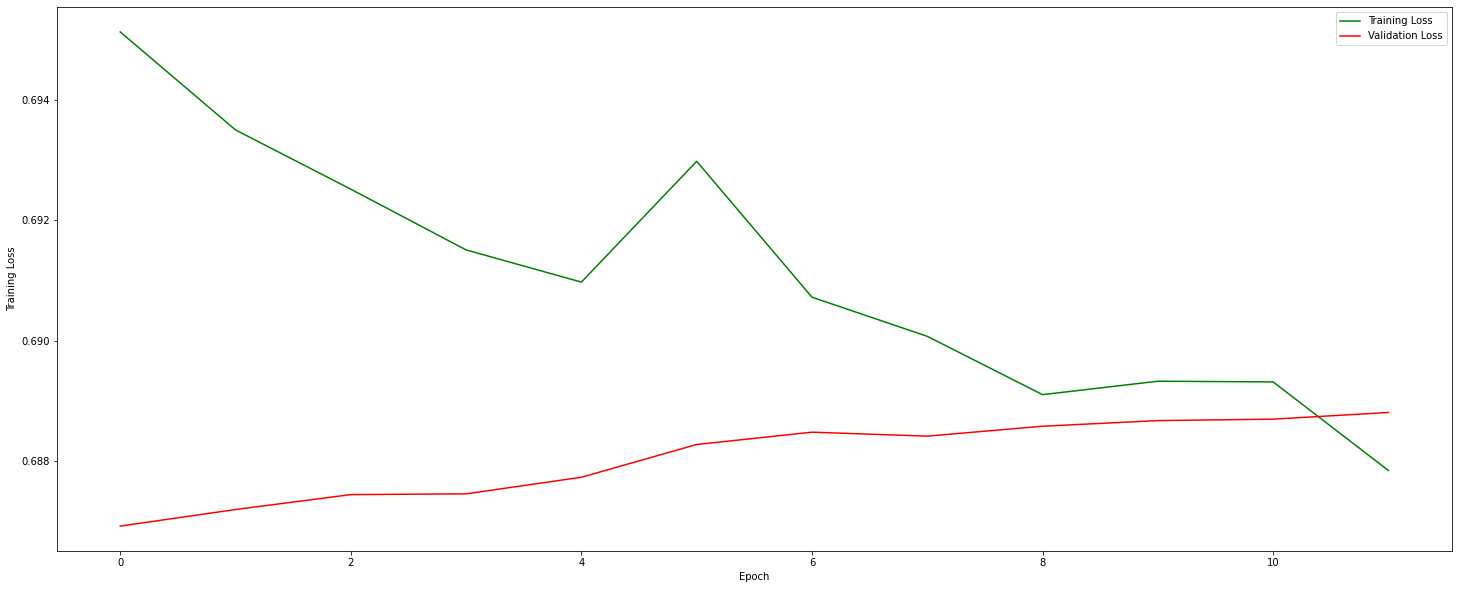

In [158]:
plot_epoch_loss(losses_train[(0.0001,12,32,0.3)])

In [159]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.0001, 12, 32, 0.3)",overall,class_scores,0.532710,0.495652,0.575758,0.496222,0.496422
1,"(0.0001, 12, 32, 0.3)",cluster1,class_scores,0.544643,0.488000,0.616162,0.487437,0.488081
2,"(0.0001, 12, 32, 0.3)",cluster2,class_scores,0.519608,0.504762,0.535354,0.505051,0.505051


In [259]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_st(df=rel_df,
                                                                     cp=(220, 173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                       learning_rates=[0.0001],
                                                                       epochs=[8],
                                                                       batch_sizes=[16],
                                                                       with_attention=True,
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Y1 Pred Dist : 
1 : 430
0 : 349
Predicted Label Shape : (779,)
True Label Shape : (779,)
Predicted Label Shape : (708,)
True Label Shape : (708,)
Predicted Label Shape : (71,)
True Label Shape : (71,)

Finished running 'evaluate_st' in 0.0130 mins

Y1 Pred Dist : 
1 : 202
0 : 195
Predicted Label Shape : (397,)
True Label Shape : (397,)
Predicted Label Shape : (199,)
True Label Shape : (199,)
Predicted Label Shape : (198,)
True Label Shape : (198,)

Finished running 'evaluate_st' in 0.0087 mins


Finished running 'run_ssda_ST' in 0.1648 mins



In [260]:
single_task_att_m = model_dict[(0.0001,8,16,0.1)]

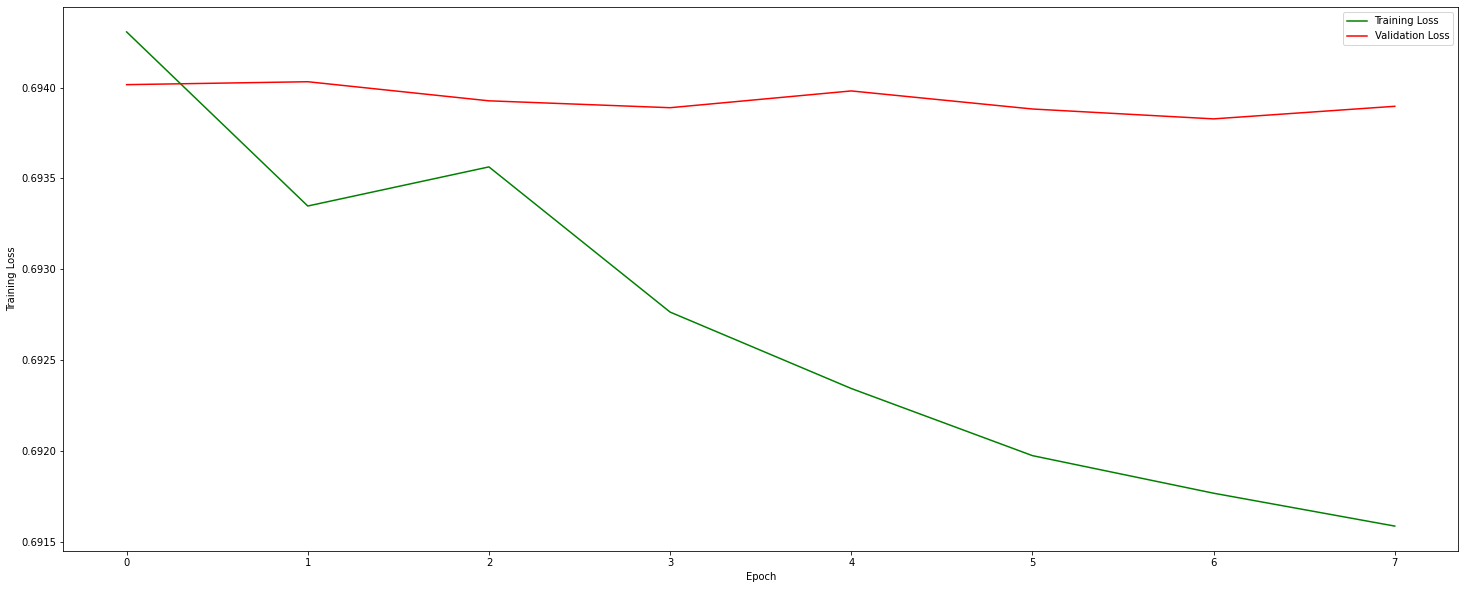

In [261]:
plot_epoch_loss(losses_train[(0.0001,8,16,0.1)])

In [262]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.0001, 8, 16, 0.1)",overall,class_scores,0.536497,0.536558,0.536546,0.536524,0.536546
1,"(0.0001, 8, 16, 0.1)",cluster1,class_scores,0.557778,0.557840,0.557828,0.557789,0.557828
2,"(0.0001, 8, 16, 0.1)",cluster2,class_scores,0.515102,0.515158,0.515152,0.515152,0.515152


In [169]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.6],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Y1 Pred Dist : 
1 : 645
0 : 134
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0140 mins

Y1 Pred Dist : 
1 : 321
0 : 76
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0080 mins


Finished running 'run_ssda_MT' in 0.2549 mins



In [170]:
model_dict.keys()

dict_keys([(0.001, 12, 16, 0.1)])

In [172]:
multi_task_att_m = model_dict[(0.001, 12, 16, 0.1)]

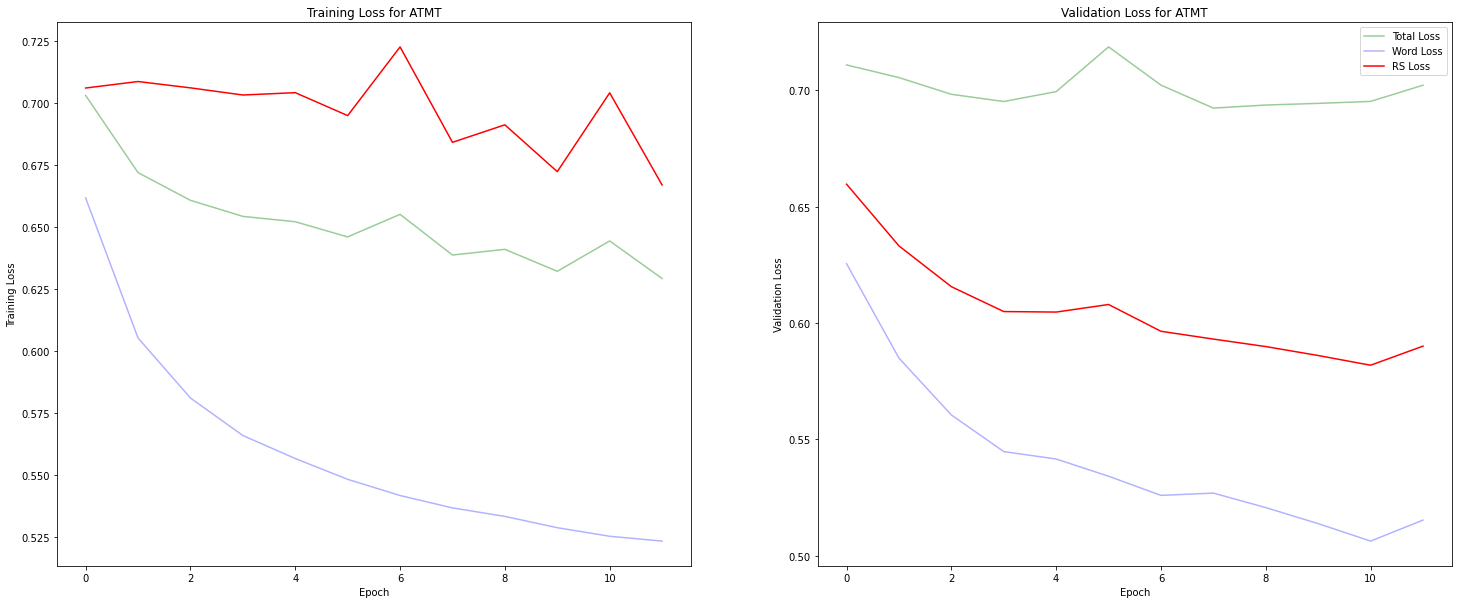

In [173]:
plot_epoch_loss_multi(losses_train[(0.001,12,16,0.1,0.6)])

In [174]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 12, 16, 0.1, 0.6)",overall,class_scores,0.631985,0.510903,0.828283,0.518892,0.519669
2,"(0.001, 12, 16, 0.1, 0.6)",cluster1,class_scores,0.630769,0.509317,0.828283,0.517588,0.519141
4,"(0.001, 12, 16, 0.1, 0.6)",cluster2,class_scores,0.633205,0.512500,0.828283,0.520202,0.520202


## Attention Check

In [212]:
def get_test_vocab(test):
    """
    """
    tokenizer = load_tokenizer()
    tokens_vocab = Counter()
    for text in test:
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"]
        tokens = tokenizer.covert_ids_to_tokens(token_tensors)
        tokens_vocab.update(tokens)
    return tokens_vocab.keys()
        
def get_attention_weights(model,test,single=True):
    """
    """
    # RUn throught the test set and get corresponding attentions scores for words in our test vocabulary
    # aggregate and return
    tokenizer = load_tokenizer()
    
    bmodel = load_model()
    bmodel.to(torch.device('cuda:1'))
    bmodel.eval()
    
    cw_embed_val = get_bert_embeddings(test,bmodel,tokenizer)
    
    if single:
        test = CPDatasetST(test)
    
    if not single:
        test = CPDatasetMT(test,cw_embed_val)
    
    test_dataloader = DataLoader(test,batch_size=1,num_workers=1, shuffle=True)
    tokenizer = load_tokenizer()
    
    attention_weights = defaultdict(list)
    
    model.eval()
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):

            if single:
                x1 = data[0]
                y1 = data[1]
                t1 = data[2]
                wc = data[3]


            if not single:
                x1 = data[0]
                x2 = data[1]
                y1 = data[2]
                t1 = data[3]
                wc = data[4]
            
            tokens = tokenizer.encode(t1[0], add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
            token_ids = tokenizer.convert_ids_to_tokens(tokens.flatten())

            x1 = x1.to(torch.device('cuda:1'))

            if single:
                y_pred = model(x1)

            if not single:
                y_pred, context_pred = model(x1,None)

            att_w = model.normalized_word_weights.cpu().numpy()

            for i in range(350):

                attention_weights[token_ids[i]].append(att_w[i])
    
    return attention_weights

def aggregate_attW(attw):
    """
    """
    agg_att_w = {}
    for token in attw.keys():
        agg_att_w[token] = np.mean(attw[token])
    
    return agg_att_w

def rank_weights(attw):
    """
    """
    sortedattw = sorted(attw.items(),key=lambda x:x[1],reverse=True)
    token_ranks = {}
    for rank, token_tuple in enumerate(sortedattw):
        token_ranks[token_tuple[0]] = rank
    
    return token_ranks
    

def calc_change_in_rank(testwa1,testwa2):
    """
    iterate through words in vocab and check difference in ranks
    """
    agg_aw1 = aggregate_attW(testwa1)
    agg_aw2 = aggregate_attW(testwa2)
    
    aw1_ranks = rank_weights(agg_aw1)
    aw2_ranks = rank_weights(agg_aw2)
    
    assert len(aw1_ranks.keys()) == len(aw2_ranks.keys())
    
    change_in_rank = {}
    for token in aw1_ranks.keys():
        change_in_rank[token] = aw1_ranks[token] - aw2_ranks[token]
    
    return change_in_rank


In [177]:
train,test,val = split_data(cluster_pair=(220,173),cluster_2_doc_map=doc_2_cluster_map,df=rel_df)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


In [178]:
train = train[train.doc_indices <= 99402 ]
test = test[test.doc_indices <= 99402 ]
val = val[val.doc_indices <= 99402 ]

In [263]:
single_t_att_w =  get_attention_weights(single_task_att_m,test,single=True)

100%|██████████| 397/397 [00:02<00:00, 135.66it/s]


In [264]:
len(single_t_att_w.keys())

9207

In [265]:
len(single_t_att_w["[CLS]"])

397

In [218]:
multi_att_w = get_attention_weights(multi_task_att_m,test,single=False)

100%|██████████| 397/397 [00:02<00:00, 136.72it/s]


In [219]:
len(multi_att_w.keys())

9207

In [220]:
len(multi_att_w["[CLS]"])

397

In [266]:
rank_changes = calc_change_in_rank(single_t_att_w,multi_att_w)

In [267]:
rank_changes_list = list(rank_changes.items())

## Top Attention Weights Single Task

In [268]:
single_t_att_w_agg = aggregate_attW(single_t_att_w)

In [269]:
ranks = sorted(list(single_t_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [270]:
print(ranks)

[('visible', 0.008742467), ('shouldered', 0.00783054), ('tighter', 0.0074774115), ('bulgarian', 0.0071010753), ('prefer', 0.0070933523), ('whistling', 0.0068607153), ('rides', 0.006621324), ('stacey', 0.006617042), ('northward', 0.0064484314), ('horrible', 0.0063214195), ('subordinate', 0.006244776), ('##rgeon', 0.0061712605), ('affecting', 0.006132195), ('ounce', 0.006083756), ('dim', 0.006078904), ('23', 0.0059510055), ('flavor', 0.0059125973), ('nowhere', 0.0058388696), ('##agger', 0.0058267387), ('min', 0.0058179325), ('ride', 0.0058140457), ('coughing', 0.0058088), ('exhibits', 0.0057873144), ('mercy', 0.0057870047), ('drum', 0.0057868087)]


## Top Attention Weights Multi Task

In [271]:
multi_att_w_agg = aggregate_attW(multi_att_w)

In [272]:
ranks = sorted(list(multi_att_w_agg.items()),key=lambda x:x[1],reverse=True)[:25]

In [273]:
print(ranks)

[('mainly', 0.2289909), ('cave', 0.19626273), ('##eg', 0.12193539), ('olympia', 0.0788926), ('casualties', 0.067569196), ('rotation', 0.060067974), ('testify', 0.036080007), ('price', 0.033805784), ('settle', 0.033466365), ('##nds', 0.032529738), ('##leen', 0.031365406), ('strongly', 0.027875667), ('prayers', 0.027593013), ('mention', 0.026004944), ('risky', 0.025978157), ('##za', 0.022125179), ('##metric', 0.022041688), ('locations', 0.020374818), ('proportion', 0.019904548), ('acquire', 0.019758273), ('passengers', 0.01962379), ('##tee', 0.019446388), ('bot', 0.01933808), ('furious', 0.018777391), ('decrees', 0.017739514)]


## Rank Increase

In [274]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=True)[:20]

[('##ret', 9102),
 ('rotation', 9087),
 ('##lifting', 9057),
 ('bottled', 9036),
 ('olympia', 8991),
 ('winkler', 8964),
 ('ghost', 8953),
 ('crafts', 8909),
 ('patriot', 8901),
 ('sharp', 8900),
 ('statutes', 8892),
 ('viewing', 8886),
 ('##mar', 8879),
 ('acute', 8866),
 ('matt', 8851),
 ('anthropology', 8851),
 ('evaluate', 8848),
 ('italian', 8833),
 ('crosses', 8830),
 ('##rit', 8809)]

## Rank Decrease

In [275]:
sorted(rank_changes_list,key=lambda x: x[1], reverse=False)[:20]

[('194', -9131),
 ('sanchez', -9127),
 ('bulgarian', -9113),
 ('begging', -9112),
 ('tonight', -9108),
 ('deeper', -9104),
 ('subjects', -9098),
 ('contentious', -9079),
 ('bracing', -9066),
 ('iv', -9066),
 ('tennis', -9057),
 ('23', -9055),
 ('##unciation', -9037),
 ('laundry', -9027),
 ('hesitate', -9013),
 ('350', -9007),
 ('coughing', -9006),
 ('##naire', -9000),
 ('reluctant', -8994),
 ('instruments', -8993)]

## Specific Words

In [276]:
rank_changes["passengers"]

6266

In [277]:
rank_changes["inmates"]

-6325

In [278]:
rank_changes["gun"]

1180

In [279]:
rank_changes["wall"]

993

In [280]:
rank_changes["democrat"]

777

In [281]:
rank_changes["republican"]

-144

In [282]:
rank_changes["immigrant"]

3588

In [283]:
rank_changes["trump"]

697

In [284]:
rank_changes["border"]

1570

## Word Loss Weight Comparison

In [249]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.1,0.2,0.4,0.6,0.8,0.9],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 6
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 504
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 273
0 : 124
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2710 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 397
0 : 382
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 197
0 : 200
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2692 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


Y1 Pred Dist : 
1 : 570
0 : 209
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0141 mins

Y1 Pred Dist : 
1 : 297
0 : 100
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0084 mins


Finished running 'run_ssda_MT' in 0.2767 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Y1 Pred Dist : 
1 : 747
0 : 32
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0134 mins

Y1 Pred Dist : 
1 : 379
0 : 18
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2696 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


Y1 Pred Dist : 
1 : 17
0 : 762
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0146 mins

Y1 Pred Dist : 
1 : 5
0 : 392
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2800 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 617
0 : 162
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 330
0 : 67
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0085 mins


Finished running 'run_ssda_MT' in 0.2741 mins



In [251]:
model_dict.keys()

dict_keys([(0.001, 12, 16, 0.1)])

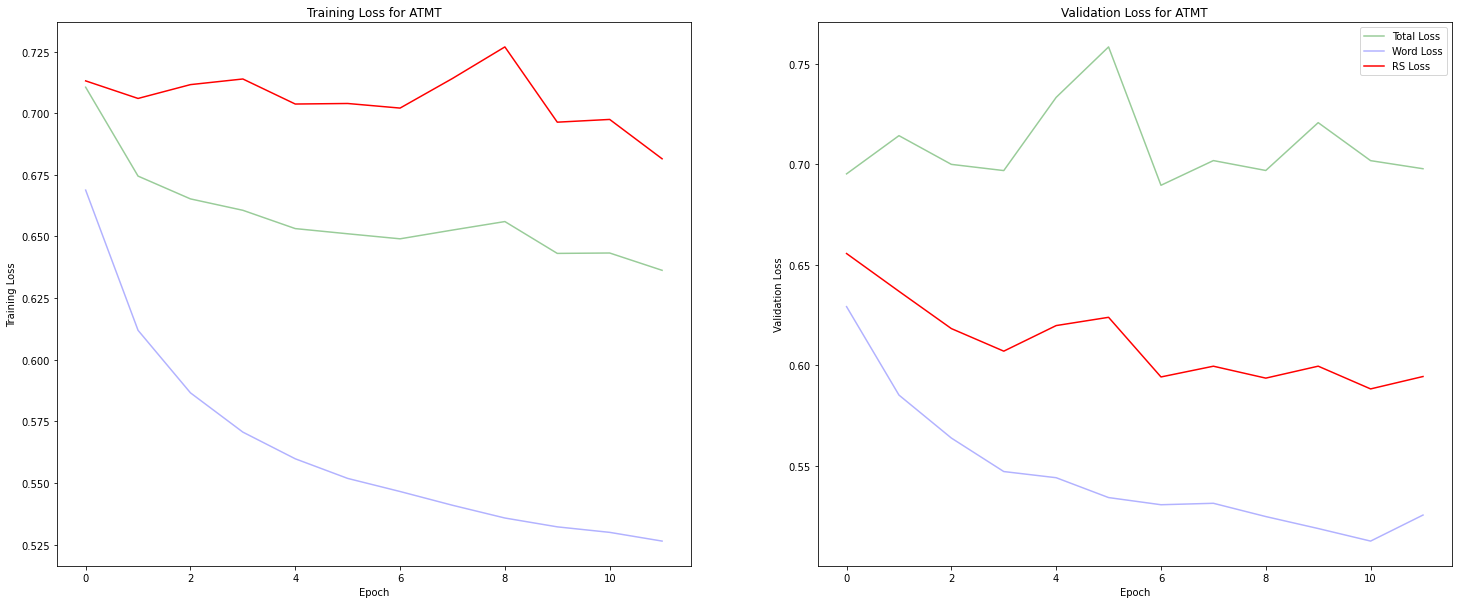

In [253]:
plot_epoch_loss_multi(losses_train[(0.001,12,16,0.1,0.6)])

In [252]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 12, 16, 0.1, 0.1)",overall,class_scores,0.602972,0.520147,0.717172,0.528967,0.529440
2,"(0.001, 12, 16, 0.1, 0.1)",cluster1,class_scores,0.652361,0.567164,0.767677,0.592965,0.593838
4,"(0.001, 12, 16, 0.1, 0.1)",cluster2,class_scores,0.554622,0.474820,0.666667,0.464646,0.464646
6,"(0.001, 12, 16, 0.1, 0.2)",overall,class_scores,0.496203,0.497462,0.494949,0.498741,0.498731
8,"(0.001, 12, 16, 0.1, 0.2)",cluster1,class_scores,0.533333,0.541667,0.525253,0.542714,0.542626
10,"(0.001, 12, 16, 0.1, 0.2)",cluster2,class_scores,0.460000,0.455446,0.464646,0.454545,0.454545
12,"(0.001, 12, 16, 0.1, 0.4)",overall,class_scores,0.602020,0.501684,0.752525,0.503778,0.504403
14,"(0.001, 12, 16, 0.1, 0.4)",cluster1,class_scores,0.634538,0.526667,0.797980,0.542714,0.543990
16,"(0.001, 12, 16, 0.1, 0.4)",cluster2,class_scores,0.569106,0.476190,0.707071,0.464646,0.464646
18,"(0.001, 12, 16, 0.1, 0.6)",overall,class_scores,0.672444,0.511873,0.979798,0.523929,0.525075


# Macro Based Metric Measures

In [257]:
metrics_train,metrics_test, losses_train,model_dict = run_ssda_cp_mt(df=rel_df,
                                                                     cp=(220,173),
                                                                     doc_2_cluster_map=doc_2_cluster_map,
                                                                     learning_rates=[0.001],
                                                                       epochs=[12],
                                                                       word_pred_loss_weights=[0.1,0.2,0.4,0.6,0.8,0.9],
                                                                       batch_sizes=[16],
                                                                       dropouts=[0.1],
                                                                       cuda_device=torch.device('cuda:1'), 
                                                                       return_model=True)

C1 Shape : (1115, 14)
C2 Shape : (658, 14)
Data Shape after balancing :
C1 Shape : (994, 16)
C2 Shape : (546, 16)
Data Sizes :
Train : (786, 16)
Val : (88, 16)
Test : (398, 16)
Label Distributions :
Train :
1 : 394
0 : 392
Val : 
1 : 44
0 : 44
Test : 
1 : 198
0 : 200


  0%|          | 0/12 [00:00<?, ?it/s]

Number of param combinations : 6
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Y1 Pred Dist : 
1 : 423
0 : 356
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0136 mins

Y1 Pred Dist : 
1 : 218
0 : 179
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2840 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.26s/it]


Y1 Pred Dist : 
1 : 426
0 : 353
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0141 mins

Y1 Pred Dist : 
1 : 217
0 : 180
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2774 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Y1 Pred Dist : 
1 : 160
0 : 619
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 66
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0089 mins


Finished running 'run_ssda_MT' in 0.2881 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 168
0 : 611
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 76
0 : 321
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0083 mins


Finished running 'run_ssda_MT' in 0.2727 mins

Param_setting : 4
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.24s/it]


Y1 Pred Dist : 
1 : 94
0 : 685
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0137 mins

Y1 Pred Dist : 
1 : 39
0 : 358
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0082 mins


Finished running 'run_ssda_MT' in 0.2724 mins

Param_setting : 5
Running model for ----
 lr : 0.001
 epoch : 12
 batch_size : 16
 dropout : 0.1



100%|██████████| 12/12 [00:14<00:00,  1.25s/it]


Y1 Pred Dist : 
1 : 763
0 : 16
Y2 Pred Dist : 
1 : 0
0 : 779
Predicted Label Shape : (779,)
True Label Shape : (779,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (708,)
True Label Shape : (708,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (71,)
True Label Shape : (71,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0143 mins

Y1 Pred Dist : 
1 : 393
0 : 4
Y2 Pred Dist : 
1 : 0
0 : 397
Predicted Label Shape : (397,)
True Label Shape : (397,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (199,)
True Label Shape : (199,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (198,)
True Label Shape : (198,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.0087 mins


Finished running 'run_ssda_MT' in 0.2745 mins



In [258]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 12, 16, 0.1, 0.1)",overall,class_scores,0.479917,0.481049,0.481232,0.481108,0.481232
2,"(0.001, 12, 16, 0.1, 0.1)",cluster1,class_scores,0.479838,0.482405,0.482778,0.482412,0.482778
4,"(0.001, 12, 16, 0.1, 0.1)",cluster2,class_scores,0.479466,0.479746,0.479798,0.479798,0.479798
6,"(0.001, 12, 16, 0.1, 0.2)",overall,class_scores,0.548190,0.549667,0.549236,0.549118,0.549236
8,"(0.001, 12, 16, 0.1, 0.2)",cluster1,class_scores,0.582239,0.583740,0.583131,0.582915,0.583131
10,"(0.001, 12, 16, 0.1, 0.2)",cluster2,class_scores,0.513912,0.515308,0.515152,0.515152,0.515152
12,"(0.001, 12, 16, 0.1, 0.4)",overall,class_scores,0.443882,0.509842,0.505457,0.506297,0.505457
14,"(0.001, 12, 16, 0.1, 0.4)",cluster1,class_scores,0.433911,0.484577,0.490859,0.492462,0.490859
16,"(0.001, 12, 16, 0.1, 0.4)",cluster2,class_scores,0.453880,0.539286,0.520202,0.520202,0.520202
18,"(0.001, 12, 16, 0.1, 0.6)",overall,class_scores,0.442729,0.492642,0.495444,0.496222,0.495444
